In [88]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import matrix_power as mpow
from numpy.linalg import norm
import matplotlib.pyplot as plt

Xi_l = -10
Xi_r = 10
dXi = 0.1
dTau = 0.005
tauMax = 10

size = int((Xi_r - Xi_l) / dXi)
Xi = np.linspace(Xi_l, Xi_r, size, endpoint=True)

## b)
Calculate $S_H$

Our grid has `size = 200` points. $\tilde{H}_{n,m}$ and $S_H$ are a `200x200` matrices.

In [89]:
delta_n_m = np.eye(size)
delta_n_mp1 = np.eye(size, k=-1)  # delta_{n,m+1}
delta_n_mm1 = np.eye(size, k=1)  # delta_{n,m-1}
# = np.arange(1, size + 1)

HamOp = -1 / dXi**2 * (delta_n_mm1 + delta_n_mp1 - 2 * delta_n_m) + Xi**2 * delta_n_m

TimeEcOpIM = 0.5j * dTau * HamOp

TimeEvOp = inv(np.eye(size) + TimeEcOpIM) @ (np.eye(size) - TimeEcOpIM)

## c)
discretise $\psi(\Epsilon,t=0)$

In [90]:
Xi_0 = 1
psi_0 = np.power(1 / (2 * np.pi), 0.25) * np.exp(-0.25 * (Xi - Xi_0) ** 2)
psi_0 /= norm(psi_0)  # normalization

## d)
calculate $\psi_n(\tau=10)$

In [91]:
num_rows_plot = 4
Pit = np.random.uniform(0, tauMax, num_rows_plot**2)  # Points in time
Pit = np.sort(Pit)
Iit = Pit / dTau  # Indices in time
Iit = Iit.astype(int)  # Indices in time as integers

steps = np.diff(Iit)
psis = [psi_0]
for i in range(len(steps)):
    psis.append(mpow(TimeEvOp, steps[i]) @ psis[-1])

(0.0, 1.25)

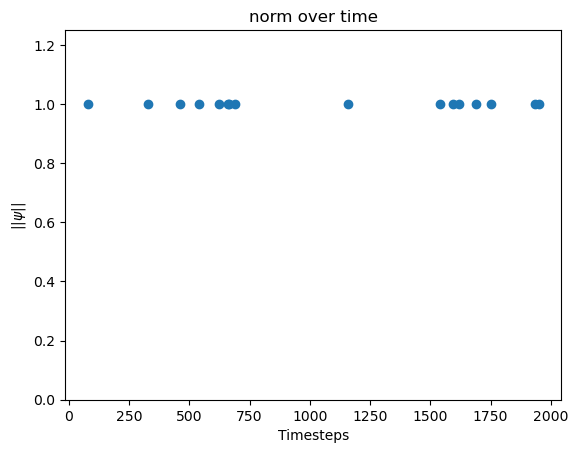

In [92]:
plt.plot(Iit, norm(psis, axis=1), linestyle="none", marker="o")
plt.xlabel("Timesteps")
plt.ylabel("$||\psi||$ ")
plt.title("norm over time")
plt.ylim(0, 1.25)

The normalization is still satisfied.

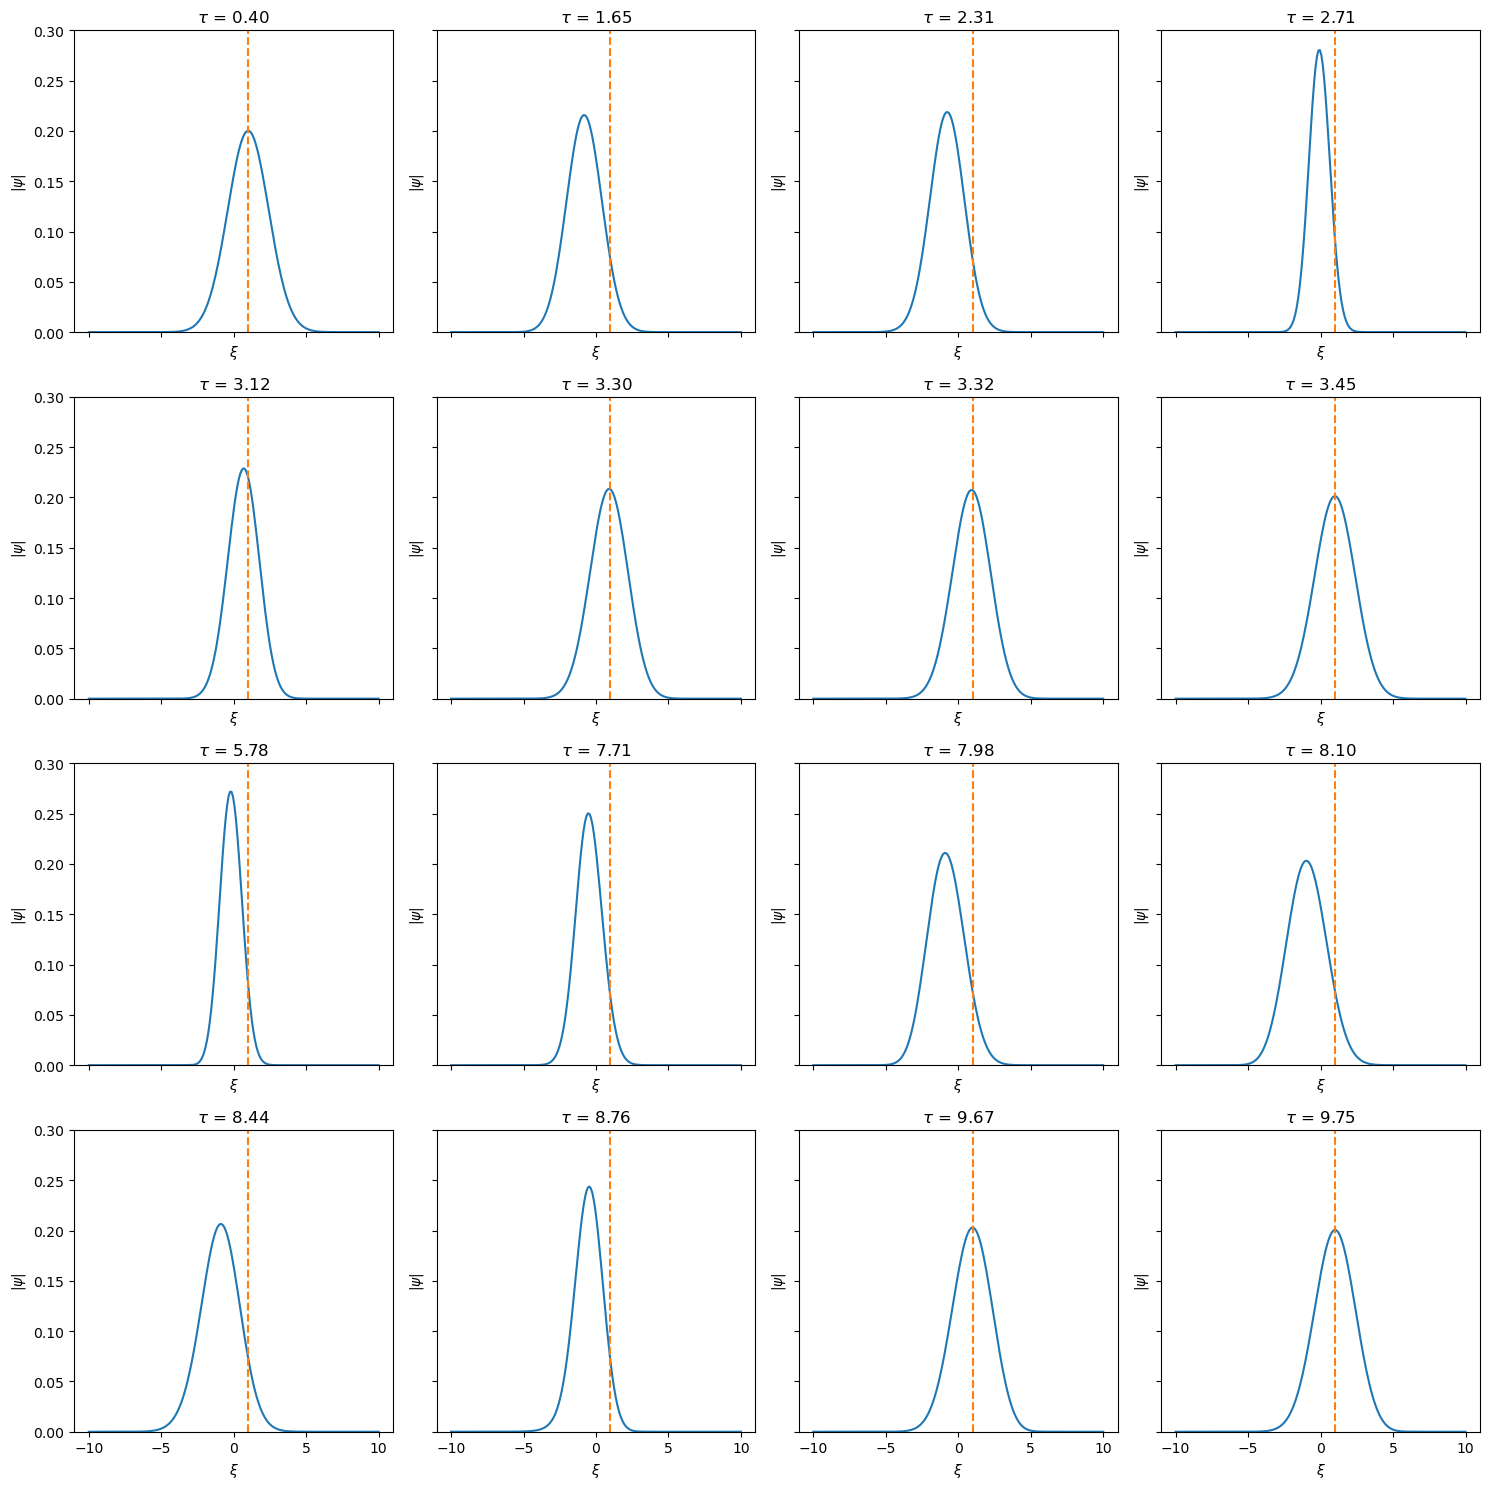

In [101]:
fig, ax = plt.subplots(
    num_rows_plot, num_rows_plot, figsize=(15, 15), sharex=True, sharey=True
)
for i, phi in enumerate(psis):
    row = i // num_rows_plot
    col = i % num_rows_plot
    ax[row, col].plot(Xi, np.abs(phi))
    ax[row, col].set_title(rf"$\tau$ = {Pit[i]:.2f}")
    ax[row, col].set_xlabel(r"$\xi$")
    ax[row, col].set_ylabel(r"$|\psi|$")
    ax[row, col].set_ylim(0, 0.3)
    ax[row, col].axvline(x=Xi_0, linestyle="--", color="tab:orange")

fig.tight_layout()

## 

## e)

calculate the mean value and the variance of the position and momentum.

Plot and discuss the classic background and the Heisenbergs uncertainty principle

In [130]:
psis2 = np.array([psi_0])
for i in range(int(tauMax / dTau)):
    psis2 = np.append(psis2, [TimeEvOp @ psis2[-1]], axis=0)

pos_density = np.abs(psis2) ** 2
pos_mean = np.sum(Xi * pos_density, axis=1)
pos_var = np.sum((Xi - pos_mean[:, np.newaxis]) ** 2 * pos_density, axis=1)

psi_mom = np.fft.fft(psis2, axis=1)
psi_mom = np.fft.fftshift(psi_mom, axes=1)
psi_mom /= norm(psi_mom, axis=1)[:, np.newaxis]
mom_density = np.abs(psi_mom) ** 2

p = np.fft.fftfreq(size, d=dXi)
p = np.fft.fftshift(p)

mom_mean = np.sum(p * mom_density, axis=1)
mom_var = np.sum((p - mom_mean[:, np.newaxis]) ** 2 * mom_density, axis=1)

(2001, 200)

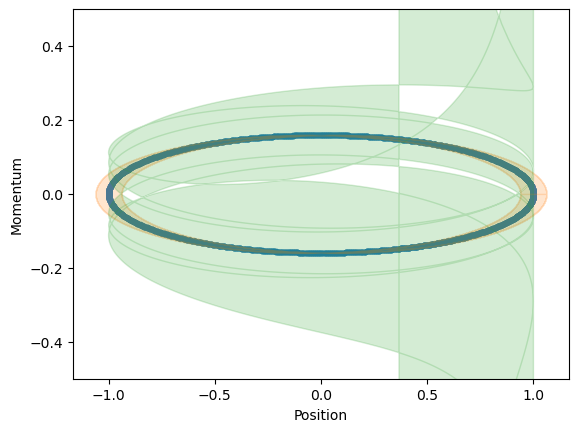

In [134]:
# Create scatter plot for mean values
plt.scatter(pos_mean, mom_mean, color="tab:blue", label="Mean Values", s=10)

# Create translucent fields for the one sigma area
plt.fill_betweenx(
    mom_mean, pos_mean - pos_std, pos_mean + pos_std, color="tab:orange", alpha=0.2
)
plt.fill_between(
    pos_mean, mom_mean - mom_std, mom_mean + mom_std, color="tab:green", alpha=0.2
)
# Create error bars for the momentum

# Add labels and legend
plt.xlabel("Position")
plt.ylabel("Momentum")
plt.ylim(-0.5, 0.5)

# Show the plot
plt.show()